In [185]:
%pip install osmnx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\CiSTUP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [186]:
%pip install rtree

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\CiSTUP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [187]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\CiSTUP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine_vector, Unit, haversine
import osmnx as ox
import pickle
import os
from tqdm import tqdm
import folium
from rtree import index

In [2]:
stops_df = pd.read_csv(r"../Datasets/bus_stop.csv")

C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_21460\2165857006.py:1: DtypeWarning: Columns (6,16,17,18,19,21,22,23,25,26,27,28,29,32,35,36,40,53,58,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  stops_df = pd.read_csv(r"../Datasets/bus_stop.csv")


In [98]:
gps_df = pd.read_csv(r"../Datasets/GPS.csv")

In [4]:
print(len(gps_df))
gps_df.head()

1000000


,DEVICE_ID,IST_DATE,LAT,LONGITUDE
0,181221399,2000-10-13 06:30:00,0.000000,77.701782
1,181221399,2000-10-13 06:30:00,0.000000,77.701782
2,181221399,2000-10-13 06:30:00,0.000000,77.701782
3,9999572791,2019-10-13 00:15:18,13.029256,77.593023
4,9999572791,2019-10-13 00:15:33,13.029256,77.593023


In [99]:
# Drop duplicate based on DEVICE_ID, IST_DATE, LAT and LONGITUDE
gps_df = gps_df.drop_duplicates(subset=['DEVICE_ID','IST_DATE','LAT','LONGITUDE'])

In [100]:
# Filter the rows which LAT and LONGITUDE are between 12 and 14 and 77 and 79
stops_df = stops_df[(stops_df['latitude_current'] > 12.8265) & (stops_df['latitude_current'] < 13.2694) & (stops_df['longitude_current'] > 77.3740) & (stops_df['longitude_current'] < 77.8313)]
gps_df = gps_df[(gps_df['LAT'] > 12) & (gps_df['LAT'] < 13.2694) & (gps_df['LONGITUDE'] > 77.3740) & (gps_df['LONGITUDE'] < 77.8313)]
print(len(gps_df))
gps_df.head()

25153843


,DEVICE_ID,IST_DATE,LAT,LONGITUDE
3,9999572791,2019-10-13 00:15:18,13.029256,77.593023
4,9999572791,2019-10-13 00:15:33,13.029256,77.593023
5,9999572791,2019-10-13 00:15:46,13.029256,77.593023
6,9999572791,2019-10-13 00:16:03,13.029256,77.593023
7,9999572791,2019-10-13 00:16:18,13.029299,77.592891


In [101]:
# Plot the data point based on year, Day and date
gps_df['IST_DATE'] = pd.to_datetime(gps_df['IST_DATE'])
gps_df['YEAR'] = gps_df['IST_DATE'].dt.year
gps_df['DAY'] = gps_df['IST_DATE'].dt.dayofweek
gps_df['DATE'] = gps_df['IST_DATE'].dt.date
gps_df['TIME'] = gps_df['IST_DATE'].dt.time

In [102]:
gps_df['DATE'].value_counts()

DATE
2019-10-13    25153837
2000-10-13           3
2001-10-13           2
1970-10-13           1
Name: count, dtype: int64

In [103]:
# Remove the data points which are not in 2019
gps_df = gps_df[gps_df['YEAR'] == 2019]

In [104]:
# Sort the dataframe by DEVICE_ID and then by IST_DATE
gps_df = gps_df.sort_values(by=['DEVICE_ID','IST_DATE'])
gps_df.head()

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME
2916,150211826,2019-10-13 00:00:03,13.043971,77.594109,2019,6,2019-10-13,00:00:03
4050,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13
5156,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23
6241,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33
7208,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43


In [105]:
# Shift the rows by 1 and get the previous row's LAT and LONGITUDE and IST_DATE
gps_df['PREV_LAT'] = gps_df.groupby(['DEVICE_ID'])['LAT'].shift(1)
gps_df['PREV_LONGITUDE'] = gps_df.groupby(['DEVICE_ID'])['LONGITUDE'].shift(1)
gps_df['PREV_IST_DATE'] = gps_df.groupby(['DEVICE_ID'])['IST_DATE'].shift(1)
gps_df.head()

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE
2916,150211826,2019-10-13 00:00:03,13.043971,77.594109,2019,6,2019-10-13,00:00:03,NaN,NaN,NaT
4050,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13,13.043971,77.594109,2019-10-13 00:00:03
5156,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23,13.043971,77.594109,2019-10-13 00:00:13
6241,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33,13.043971,77.594109,2019-10-13 00:00:23
7208,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43,13.043971,77.594109,2019-10-13 00:00:33


In [106]:
# Drop the na values
gps_df = gps_df.dropna()

In [107]:
# Calculate the distance between the current row and the previous row using haversine formula
gps_df['DISTANCE'] = haversine_vector(gps_df[['LAT','LONGITUDE']],gps_df[['PREV_LAT','PREV_LONGITUDE']],Unit.METERS)

In [108]:
# Calculate the time difference between the current row and the previous row
gps_df['TIME_DIFF'] = (pd.to_datetime(gps_df['IST_DATE']) - pd.to_datetime(gps_df['PREV_IST_DATE'])).dt.total_seconds()

In [64]:
print(len(gps_df))
gps_df.head()

25148761


,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF
4050,150211826,2019-10-13 00:00:13,13.043971,77.594109,2019,6,2019-10-13,00:00:13,13.043971,77.594109,2019-10-13 00:00:03,0.0,10.0
5156,150211826,2019-10-13 00:00:23,13.043971,77.594109,2019,6,2019-10-13,00:00:23,13.043971,77.594109,2019-10-13 00:00:13,0.0,10.0
6241,150211826,2019-10-13 00:00:33,13.043971,77.594109,2019,6,2019-10-13,00:00:33,13.043971,77.594109,2019-10-13 00:00:23,0.0,10.0
7208,150211826,2019-10-13 00:00:43,13.043971,77.594109,2019,6,2019-10-13,00:00:43,13.043971,77.594109,2019-10-13 00:00:33,0.0,10.0
8146,150211826,2019-10-13 00:00:53,13.043971,77.594109,2019,6,2019-10-13,00:00:53,13.043971,77.594109,2019-10-13 00:00:43,0.0,10.0


In [109]:
sum(gps_df.groupby(['DEVICE_ID'])['DISTANCE'].sum() < 10000)
gps_df = gps_df[gps_df.groupby(['DEVICE_ID'])['DISTANCE'].transform('sum') > 10000]

# # plot the distance distribution
# plt.figure(figsize=(10,5))
# plt.hist(gps_df.groupby(['DEVICE_ID'])['DISTANCE'].sum(),bins=100)
# plt.xlabel('Distance')
# plt.ylabel('Frequency')
# plt.title('Distance Distribution')
# plt.show()


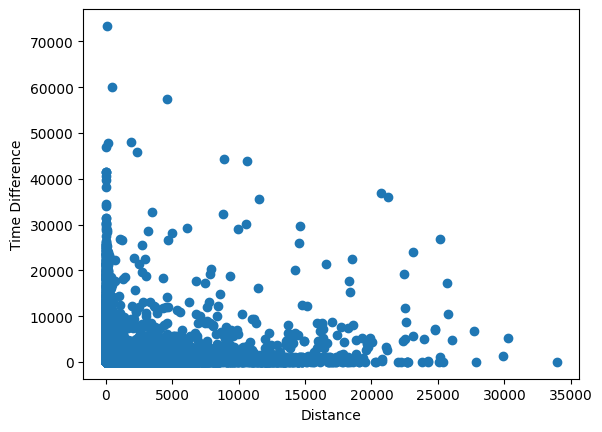

In [85]:
# PLot the distance and time difference
plt.scatter(gps_df['DISTANCE'],gps_df['TIME_DIFF'])
plt.xlabel('Distance')
plt.ylabel('Time Difference')
plt.show()

In [110]:
gps_df['TIME_DIFF'].sort_values(ascending=False).value_counts()

TIME_DIFF
10.0       20443840
9.0         1822109
11.0         604176
60.0         529345
59.0         279702
             ...   
2586.0            1
2589.0            1
2603.0            1
2607.0            1
73382.0           1
Name: count, Length: 3514, dtype: int64

In [111]:
gps_df = gps_df[gps_df['TIME_DIFF'] <= 70]

In [112]:
gps_df = gps_df[gps_df['TIME_DIFF'] != 0]

In [113]:
sum(gps_df['TIME_DIFF'] == 0)

0

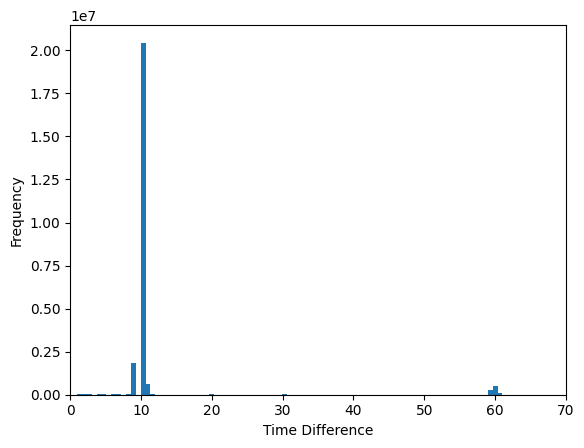

In [114]:
# plot the histogram of time difference 
plt.hist(gps_df['TIME_DIFF'],bins=100)
plt.xlabel('Time Difference')
plt.ylabel('Frequency')
plt.xlim(0,70)
plt.show()



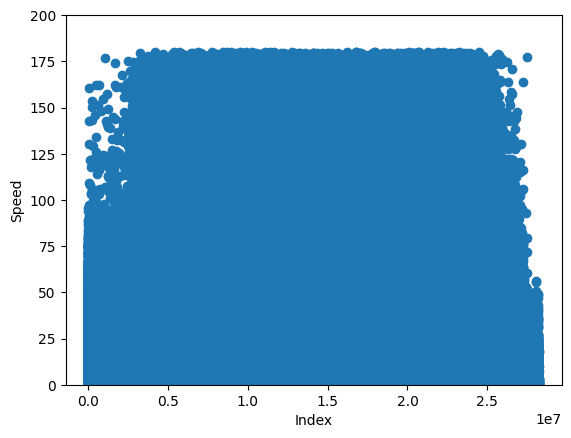

In [118]:
gps_df['SPEED'] = gps_df['DISTANCE'] / (gps_df['TIME_DIFF'] +0.0001) *18/5

# Plot the scatter plot speed with respect index
plt.scatter(gps_df.index,gps_df['SPEED'])
plt.ylim(0,200)
plt.xlabel('Index')
plt.ylabel('Speed')
plt.show()

In [117]:
gps_df = gps_df[gps_df['SPEED'] <= 180] 

In [120]:
gps_df.to_csv(r"../Datasets/GPS_clean.csv",index=False)

In [119]:
# Value counts of speed between 0 and 1
gps_df[(gps_df['SPEED'] > 0) & (gps_df['SPEED'] < 1)]['SPEED'].value_counts()

SPEED
0.040030    364668
0.040030    248851
0.080060     88015
0.040030     44881
0.120089     39429
             ...  
0.322126         1
0.618328         1
0.350734         1
0.350734         1
0.814654         1
Name: count, Length: 1146129, dtype: int64

In [121]:
gps_df['SPEED'].min()

0.0

In [122]:
gps_df.shape

(24105828, 14)

In [123]:
# reset the index
gps_df = gps_df.reset_index(drop=True)

# Add column stop_time and initialize it with 0
gps_df['STOP_TIME'] = 0

# Take the dataframe with speed 0
gps_df0 = gps_df[gps_df['SPEED'] <= 1]

# # Iterate over the dataframe with speed 0 and add the time_diff with the previous rows STOP_TIME to the current row STOP_TIME
prev_index = 0
for index,row in tqdm(gps_df0.iterrows(),total=len(gps_df0)):
    if index > 0 and row['DEVICE_ID'] == gps_df0.loc[prev_index,'DEVICE_ID']:
        gps_df.loc[index,'STOP_TIME'] = gps_df.loc[index-1,'STOP_TIME'] + row['TIME_DIFF']
    else:
        gps_df.loc[index,'STOP_TIME'] = row['TIME_DIFF']
    prev_index = index
    


100%|██████████| 13219539/13219539 [40:48<00:00, 5399.05it/s]


In [124]:
gps_df.to_csv(r"../Datasets/GPS_clean_1.csv",index=False)

In [125]:
gps_df_copy = gps_df.copy()

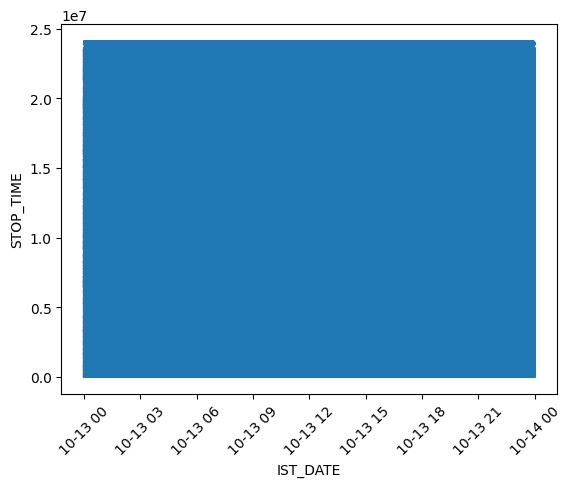

In [126]:
# plot IST_DATE of device id 150211826 with index
plt.plot(gps_df[:]['IST_DATE'],gps_df.index)   
plt.xlabel('IST_DATE')
plt.ylabel('STOP_TIME')
plt.xticks(rotation=45)
plt.show()


In [127]:
len(gps_df0)

13219539

In [132]:
# number of unique lat and long
gps_df.groupby(['LAT','LONGITUDE']).size().shape

(10338457,)

In [129]:
gps_df.shape

(24105828, 15)

In [130]:
st = gps_df.loc[gps_df['STOP_TIME'] > 600,['LAT','LONGITUDE']].groupby(['LAT','LONGITUDE']).count()
st = st.reset_index()

In [51]:
g = gps_df[((gps_df['LAT'].isin(st['LAT'])) & (gps_df['LONGITUDE'].isin(st['LONGITUDE'])) & (gps_df['SPEED'] > 10) & (gps_df['SPEED'] < 120))]

In [52]:
len(g)

1208

In [225]:
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for id,row in g.iterrows():
    folium.CircleMarker(location=[row['LAT'],row['LONGITUDE']],radius=0.01,color='red').add_to(m)
m.save('map.html')

In [145]:
# Filter the gps_df with respect to STOP_TIME less than 600 and LAT and LONGITUDE are not in st
gps_df = gps_df[gps_df['STOP_TIME'] < 300]

gps_df = gps_df[~((gps_df['LAT'].isin(st['LAT'])) & (gps_df['LONGITUDE'].isin(st['LONGITUDE'])) & (gps_df['SPEED'] < 10))]

len(gps_df)


12765218

In [136]:
gps_df['DEVICE_ID'].unique().shape

(4684,)

In [146]:
sum(gps_df.groupby(['DEVICE_ID'])['DISTANCE'].sum() < 20000)

gps_df = gps_df[gps_df.groupby(['DEVICE_ID'])['DISTANCE'].transform('sum') > 20000]

In [147]:
len(gps_df)

12765218

In [148]:
gps_df_1 = gps_df[:1000][:]

In [149]:
G = ox.graph_from_place("Bangalore, India", network_type="drive")

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Load OSMnx graph (replace with your OSMnx graph creation)
# G = ox.graph_from_place("Bangalore, India", network_type="drive")

# Assuming 'lat' and 'lon' are your latitude and longitude columns
# Replace 'your_dataframe' with your actual DataFrame
geometry = [Point(lon, lat) for lat, lon in zip(gps_df_1['LAT'], gps_df_1['LONGITUDE'])]
gdf_points = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Spatial index for the OSMnx graph
spatial_index = gdf_points.sindex

# Find the nearest edge for each point
nearest_edges = []
for point in gdf_points['geometry']:
    possible_matches_index = list(spatial_index.intersection(point.bounds))
    possible_matches = gdf_points.iloc[possible_matches_index]
    nearest_edge = possible_matches.geometry.distance(point).idxmin()
    nearest_edges.append(nearest_edge)

# 'nearest_edges' now contains the indices of the nearest edge for each point


In [ ]:
nearest_edges

In [227]:
# Plot the st and stops_df on folium plot in different colours and as circular markers
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in st.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='red',fill=True).add_to(m)
for index,row in stops_df.iterrows():
    folium.CircleMarker([row['latitude_current'],row['longitude_current']],radius=0.01,color='blue',fill=True).add_to(m)
m.save('stops.html')

In [228]:
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in st.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='red',fill=True).add_to(m)
for index,row in gps_df.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='blue',fill=True).add_to(m)
m.save('pings.html')

In [230]:
gps_df_copy = gps_df.copy()

In [229]:
# Filter the gps data with respect to speed less than 60
gps_df = gps_df[gps_df['SPEED'] < 120]
print(gps_df.SPEED.mean())

11.621991914332925


In [231]:
# Value counts of speed
print(len(gps_df))
gps_df['SPEED'].value_counts()

108927


SPEED
0.000000    27660
0.040030     2544
0.040030     1723
0.080060      880
0.120089      509
            ...  
0.447118        1
0.393760        1
0.644270        1
1.024177        1
6.419957        1
Name: count, Length: 67719, dtype: int64

In [232]:
# Get the number of unique gps based on LAT and LONGITUDE
gps_df.groupby(['LAT','LONGITUDE']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False)

,LAT,LONGITUDE,count
18165,12.918879,77.570648,62
15732,12.913798,77.486481,61
44192,12.979038,77.571579,61
41497,12.972120,77.441902,61
55025,13.016982,77.556625,61
...,...,...,...
27667,12.951047,77.537132,1
27666,12.951046,77.537086,1
27665,12.951042,77.537140,1
27664,12.951041,77.536324,1


In [233]:
# Find stop-stop segments from stop_times.txt
stop_times_df = pd.read_csv(r"../Datasets/route_point.csv")
stop_times_df.head()

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date
0,11459,1078,6461,16396,1,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27
1,11460,1078,7193,16396,2,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27
2,11461,1078,6422,20415,3,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14
3,11462,1078,6692,20417,4,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14
4,11463,1078,8537,20420,5,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14


In [235]:
def check_ping(point1,point2,ping):
    if ping[0] >= min(point1[0],point2[0]) and ping[0] <= max(point1[0],point2[0]) and ping[1] >= min(point1[1],point2[1]) and ping[1] <= max(point1[1],point2[1]):
        return True
    else:
        return False

In [236]:
# Filter the gps_df with respect to DISTANCE more than 10
gps_df.loc[gps_df['DISTANCE'] > 100,:].head(100)

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME
10219,150218092,2019-10-13 00:16:38,13.100882,77.594566,2019,6,2019-10-13,00:16:38,13.100743,77.595528,2019-10-13 00:16:28,105.325773,10.0,37.916899,0
10481,150218092,2019-10-13 01:05:38,13.100422,77.594093,2019,6,2019-10-13,01:05:38,13.101275,77.595047,2019-10-13 01:05:28,140.254232,10.0,50.491019,0
10494,150218092,2019-10-13 01:07:48,13.101042,77.594955,2019,6,2019-10-13,01:07:48,13.100422,77.594093,2019-10-13 01:07:38,116.052139,10.0,41.778352,0
10596,150218092,2019-10-13 01:24:44,13.100133,77.595184,2019,6,2019-10-13,01:24:44,13.101094,77.594727,2019-10-13 01:24:34,117.763951,10.0,42.394599,0
10632,150218092,2019-10-13 01:30:43,13.101383,77.594994,2019,6,2019-10-13,01:30:43,13.100133,77.595184,2019-10-13 01:30:33,140.508758,10.0,50.582647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18142,150218177,2019-10-13 00:13:08,13.042373,77.590225,2019,6,2019-10-13,00:13:08,13.043338,77.590660,2019-10-13 00:12:58,117.194156,10.0,42.189474,0
18143,150218177,2019-10-13 00:13:18,13.041087,77.589867,2019,6,2019-10-13,00:13:18,13.042373,77.590225,2019-10-13 00:13:08,148.162324,10.0,53.337903,0
18144,150218177,2019-10-13 00:13:28,13.039785,77.589577,2019,6,2019-10-13,00:13:28,13.041087,77.589867,2019-10-13 00:13:18,148.145161,10.0,53.331725,0
18148,150218177,2019-10-13 00:14:08,13.037017,77.589294,2019,6,2019-10-13,00:14:08,13.038179,77.589371,2019-10-13 00:13:58,129.477648,10.0,46.611487,0


In [237]:
gps_df_bus1 = gps_df.loc[gps_df['DEVICE_ID'] == 150218177,:]
gps_df_bus1.head(100)

,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME
18060,150218177,2019-10-13 00:00:11,13.172057,77.633171,2019,6,2019-10-13,00:00:11,13.173712,77.633881,2019-10-13 00:00:01,199.437765,10.0,71.796877,0
18061,150218177,2019-10-13 00:00:21,13.170369,77.632385,2019,6,2019-10-13,00:00:21,13.172057,77.633171,2019-10-13 00:00:11,206.088118,10.0,74.190981,0
18062,150218177,2019-10-13 00:00:31,13.168621,77.631561,2019,6,2019-10-13,00:00:31,13.170369,77.632385,2019-10-13 00:00:21,213.865922,10.0,76.990962,0
18063,150218177,2019-10-13 00:00:41,13.167176,77.630875,2019,6,2019-10-13,00:00:41,13.168621,77.631561,2019-10-13 00:00:31,177.013323,10.0,63.724159,0
18064,150218177,2019-10-13 00:00:51,13.165515,77.630089,2019,6,2019-10-13,00:00:51,13.167176,77.630875,2019-10-13 00:00:41,203.358253,10.0,73.208239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18155,150218177,2019-10-13 00:15:08,13.027748,77.585861,2019,6,2019-10-13,00:15:08,13.029371,77.586540,2019-10-13 00:14:58,194.884696,10.0,70.157789,0
18156,150218177,2019-10-13 00:15:17,13.026059,77.585358,2019,6,2019-10-13,00:15:17,13.027748,77.585861,2019-10-13 00:15:08,195.554019,9.0,78.220739,0
18157,150218177,2019-10-13 00:15:25,13.024752,77.585060,2019,6,2019-10-13,00:15:25,13.026059,77.585358,2019-10-13 00:15:17,148.874474,8.0,66.992676,0
18158,150218177,2019-10-13 00:15:27,13.024473,77.584984,2019,6,2019-10-13,00:15:27,13.024752,77.585060,2019-10-13 00:15:25,32.097386,2.0,57.772405,0


In [304]:
mergerd_busstops_routepoints = pd.merge(stop_times_df,stops_df[['bus_stop_id','latitude_current','longitude_current']],on='bus_stop_id')
mergerd_busstops_routepoints.head(5)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,latitude_current,longitude_current
0,11467,1078,8552,20434,9,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298
1,216766,6963,8552,20434,9,ACTIVE,N,N,2015-01-16 16:43:34,9,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298
2,731613,24529,8552,20434,15,ACTIVE,Y,N,2015-11-19 16:08:01,7,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298
3,1050626,34364,8552,20434,9,ACTIVE,N,N,2016-08-13 11:32:05,287,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298
4,1236873,41973,8552,20434,9,ACTIVE,N,N,2018-03-02 15:07:31,287,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.217564,77.831298


In [305]:
# sortby route_id and then by route_order
mergerd_busstops_routepoints = mergerd_busstops_routepoints.sort_values(by=['route_id','route_order'])
mergerd_busstops_routepoints.head(5)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,latitude_current,longitude_current
0,11467,1078,8552,20434,9,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298
6,11469,1078,7184,23583,11,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.200463,77.824973
14,11470,1078,8551,20509,12,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.193236,77.813080
21,11471,1078,7182,20511,13,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.188939,77.805421
30,11472,1078,6380,20511,14,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.803090


In [306]:
print(len(mergerd_busstops_routepoints))
print(mergerd_busstops_routepoints.route_id.nunique())

603027
24052


In [307]:
# Rename latitude_current and longitude_current to origin_lat and origin_long
mergerd_busstops_routepoints = mergerd_busstops_routepoints.rename(columns={'latitude_current':'origin_lat','longitude_current':'origin_long'})


In [308]:
# Create a new column destination_lat and destination_long and assign with the next row's origin_lat and origin_long for same route_id
mergerd_busstops_routepoints['destination_lat'] = mergerd_busstops_routepoints.groupby(['route_id'])['origin_lat'].shift(-1)
mergerd_busstops_routepoints['destination_long'] = mergerd_busstops_routepoints.groupby(['route_id'])['origin_long'].shift(-1)
# Drop the na values based on destination_lat and destination_long
mergerd_busstops_routepoints = mergerd_busstops_routepoints.dropna(subset=['destination_lat','destination_long'])
mergerd_busstops_routepoints.head(5)


,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,origin_lat,origin_long,destination_lat,destination_long
0,11467,1078,8552,20434,9,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.217564,77.831298,13.200463,77.824973
6,11469,1078,7184,23583,11,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.200463,77.824973,13.193236,77.813080
14,11470,1078,8551,20509,12,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.193236,77.813080,13.188939,77.805421
21,11471,1078,7182,20511,13,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.188939,77.805421,13.186616,77.803090
30,11472,1078,6380,20511,14,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.803090,13.185551,77.800190


In [309]:
# print the length of the dataframe
print(len(mergerd_busstops_routepoints))

578975


In [310]:
# Drop the duplicates based on origin_lat, origin_long, destination_lat and destination_long
mergerd_busstops_routepoints = mergerd_busstops_routepoints.drop_duplicates(subset=['origin_lat','origin_long','destination_lat','destination_long'])
# reset the index
mergerd_busstops_routepoints = mergerd_busstops_routepoints.reset_index(drop=True)
print(len(mergerd_busstops_routepoints))

37114


In [311]:
# Create length column and calculate the distance between origin_lat, origin_long and destination_lat, destination_long using haversine formula
mergerd_busstops_routepoints['length'] = haversine_vector(mergerd_busstops_routepoints[['origin_lat','origin_long']],mergerd_busstops_routepoints[['destination_lat','destination_long']],Unit.METERS)


Text(0.5, 0, 'Index')

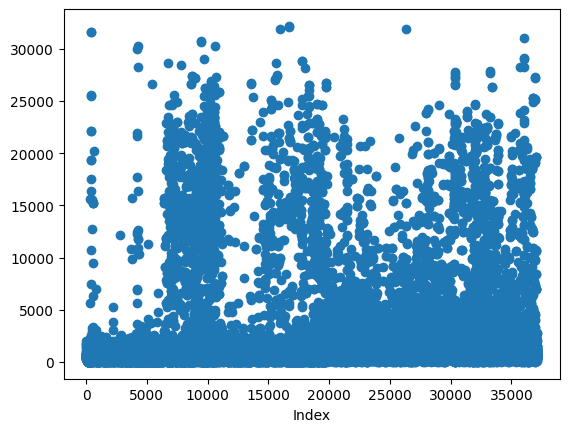

In [312]:
# Scatter Plot the length column
plt.scatter(mergerd_busstops_routepoints.index,mergerd_busstops_routepoints['length'])
plt.xlabel('Index')

In [313]:
mergerd_busstops_routepoints_copy = mergerd_busstops_routepoints.copy()

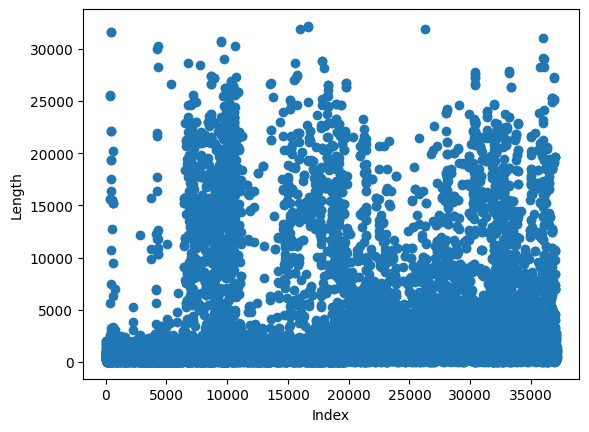

In [375]:
# Find the number of segments with length more than 5000
mergerd_busstops_routepoints = mergerd_busstops_routepoints_copy.copy()

# Filter the mergerd_busstops_routepoints with length more than 5000
# mergerd_busstops_routepoints = mergerd_busstops_routepoints[mergerd_busstops_routepoints['length'] < 2000]

# Plot the scatter plot of length column
plt.scatter(mergerd_busstops_routepoints.index,mergerd_busstops_routepoints['length'])
plt.xlabel('Index')
plt.ylabel('Length')
plt.show()

In [315]:
from rtree import index
# Create an R-tree index
idx = index.Index()
 
# Populate the R-tree index with stop segments
for i, row in mergerd_busstops_routepoints.iterrows():
    start_lat, start_lon, end_lat, end_lon = row['origin_lat'], row['origin_long'], row['destination_lat'], row['destination_long']
    idx.insert(i, (min(start_lat, end_lat), min(start_lon, end_lon), max(start_lat, end_lat), max(start_lon, end_lon)))

In [355]:
# Function to find the stop segment for a given GPS ping
def find_stop_segment(gps_lat, gps_lon):
    for segment_id in idx.intersection((gps_lat, gps_lon, gps_lat, gps_lon)):
        start_lat, start_lon, end_lat, end_lon = mergerd_busstops_routepoints.loc[segment_id, ['origin_lat', 'origin_long', 'destination_lat', 'destination_long']]
        if min(start_lat, end_lat) <= gps_lat <= max(start_lat, end_lat) and min(start_lon, end_lon) <= gps_lon <= max(start_lon, end_lon):
            l1 = haversine((gps_lat, gps_lon), (start_lat, start_lon), Unit.METERS)
            l2 = haversine((gps_lat, gps_lon), (end_lat, end_lon), Unit.METERS)
            l3 = haversine((start_lat, start_lon), (end_lat, end_lon), Unit.METERS)
            if l1 + l2 <= 1.02 * l3:
                return segment_id
    return None  # GPS ping does not belong to any stop segment

In [336]:
import osmnx as ox

G = ox.graph_from_point((13.172057, 77.633171), dist=1000, network_type='drive')

org,dest,distance = ox.nearest_edges(G, 13.172057, 77.633171)
# nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# # Ensure that the 'osmid' column is present in the nodes_gdf dataframe
# if 'osmid' not in nodes_gdf.columns:
#     nodes_gdf['osmid'] = nodes_gdf.index.astype(str)

# org_coordinates = nodes_gdf[nodes_gdf['osmid'] == str(org)][['y', 'x']]
# dest_coordinates = nodes_gdf[nodes_gdf['osmid'] == str(dest)][['geometry', 'y', 'x']]


In [381]:
# for all the gps_bus1 points create a graph for each lat long and find the nearest edge and then find the distance between the gps point and the nearest edge

# Create a new column segment_id and initialize it with 0
gps_df_bus1['start'] = 0
gps_df_bus1['end'] = 0
gps_df_bus1['distance'] = 0

# Iterate over the gps_df_bus1 dataframe

for index,row in tqdm(gps_df_bus1.iterrows(),total=len(gps_df_bus1)):

    G = ox.graph_from_point((row['LAT'], row['LONGITUDE']), dist=1000, network_type='drive')
    # Find the nearest edge and the distance between the gps point and the nearest edge
    org,dest,distance = ox.nearest_edges(G, row['LAT'], row['LONGITUDE'])
    # append start, end and distance to the gps_df_bus1 dataframe
    gps_df_bus1.loc[index,'start'] = org
    gps_df_bus1.loc[index,'end'] = dest
    gps_df_bus1.loc[index,'distance'] = distance



C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_11588\1785965460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_df_bus1['start'] = 0
C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_11588\1785965460.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_df_bus1['end'] = 0
C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_11588\1785965460.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [346]:
gps_df_bus1.distance.value_counts()

distance
0    400
1      4
Name: count, dtype: int64

In [359]:
mergerd_busstops_routepoints.head(5)

,route_points_id,route_id,bus_stop_id,bus_stop_group_id,route_order,point_status,fare_stage,sub_stage,created_date,created_by,updated_date,updated_by,deleted_status,routepoint_route_id,sync_updated_date,origin_lat,origin_long,destination_lat,destination_long,length
1,11469,1078,7184,23583,11,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.200463,77.824973,13.193236,77.813080,1517.679032
2,11470,1078,8551,20509,12,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.193236,77.813080,13.188939,77.805421,957.059694
3,11471,1078,7182,20511,13,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.188939,77.805421,13.186616,77.803090,361.103895
4,11472,1078,6380,20511,14,ACTIVE,Y,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2018-02-19 12:10:14,13.186616,77.803090,13.185551,77.800190,335.573525
5,11473,1078,5910,20511,15,ACTIVE,N,N,2014-08-20 12:09:54,10,NaN,NaN,0,NaN,2019-06-06 15:57:27,13.185551,77.800190,13.184737,77.797917,262.146791


In [ ]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Replace this with the node numbers you have
node_ids = [123456, 789012, ...]  # List of node numbers

# Create a graph from OSMnx for the city or area of your interest
place_name = "City, Country"  # Replace with the appropriate place name
G = ox.graph_from_place(place_name, network_type='drive')

# Create a subgraph using the specified nodes
subgraph = nx.subgraph(G, node_ids)

# Plot the subgraph
fig, ax = ox.plot_graph(subgraph, node_size=0, edge_color='b', bgcolor='w', show=False, close=False)
ox.plot_graph(G, node_size=0, edge_color='k', ax=ax, bgcolor='w', show=True)

# Display the plot
plt.show()


In [356]:
# create a new column segment id and find it using find_stop_segment function
gps_df_bus1['segment_id'] = gps_df_bus1.apply(lambda x: find_stop_segment(x['LAT'],x['LONGITUDE']),axis=1)
gps_df_bus1.head(100)

C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_11588\2056264803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_df_bus1['segment_id'] = gps_df_bus1.apply(lambda x: find_stop_segment(x['LAT'],x['LONGITUDE']),axis=1)


,DEVICE_ID,IST_DATE,LAT,LONGITUDE,YEAR,DAY,DATE,TIME,PREV_LAT,PREV_LONGITUDE,PREV_IST_DATE,DISTANCE,TIME_DIFF,SPEED,STOP_TIME,segment_id,start,end,distance
18060,150218177,2019-10-13 00:00:11,13.172057,77.633171,2019,6,2019-10-13,00:00:11,13.173712,77.633881,2019-10-13 00:00:01,199.437765,10.0,71.796877,0,800.0,11124434889,4676387494,0
18061,150218177,2019-10-13 00:00:21,13.170369,77.632385,2019,6,2019-10-13,00:00:21,13.172057,77.633171,2019-10-13 00:00:11,206.088118,10.0,74.190981,0,800.0,11124434889,4676387494,0
18062,150218177,2019-10-13 00:00:31,13.168621,77.631561,2019,6,2019-10-13,00:00:31,13.170369,77.632385,2019-10-13 00:00:21,213.865922,10.0,76.990962,0,800.0,6758973422,6758973400,0
18063,150218177,2019-10-13 00:00:41,13.167176,77.630875,2019,6,2019-10-13,00:00:41,13.168621,77.631561,2019-10-13 00:00:31,177.013323,10.0,63.724159,0,7324.0,6758973400,6758973422,0
18064,150218177,2019-10-13 00:00:51,13.165515,77.630089,2019,6,2019-10-13,00:00:51,13.167176,77.630875,2019-10-13 00:00:41,203.358253,10.0,73.208239,0,7324.0,11302131407,2645625964,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18155,150218177,2019-10-13 00:15:08,13.027748,77.585861,2019,6,2019-10-13,00:15:08,13.029371,77.586540,2019-10-13 00:14:58,194.884696,10.0,70.157789,0,17536.0,6738845517,529277388,0
18156,150218177,2019-10-13 00:15:17,13.026059,77.585358,2019,6,2019-10-13,00:15:17,13.027748,77.585861,2019-10-13 00:15:08,195.554019,9.0,78.220739,0,17162.0,529291262,10994338900,0
18157,150218177,2019-10-13 00:15:25,13.024752,77.585060,2019,6,2019-10-13,00:15:25,13.026059,77.585358,2019-10-13 00:15:17,148.874474,8.0,66.992676,0,7735.0,529291227,529321200,0
18158,150218177,2019-10-13 00:15:27,13.024473,77.584984,2019,6,2019-10-13,00:15:27,13.024752,77.585060,2019-10-13 00:15:25,32.097386,2.0,57.772405,0,7735.0,529277356,529018582,0


In [362]:
waybill_df = pd.read_csv(r"../Datasets/waybill.csv")
waybill_df.head()

C:\Users\CiSTUP\AppData\Local\Temp\ipykernel_11588\2416260331.py:1: DtypeWarning: Columns (16,34) have mixed types. Specify dtype option on import or set low_memory=False.
  waybill_df = pd.read_csv(r"../Datasets/waybill.csv")


,ID,WAYBILL_ID,WAYBILL_NO,DUTY_DT,COND_ID,COND_NAME,COND_TOKEN_NO,DRIVER_ID,DRIVER_NAME,DRIVER_TOKEN_NO,...,TRIP_END_TIME,TRIP_CANCEL,TRIP_CANCEL_TIME,DIST_TRAVELLED,exp_packet,act_packet,sch_travel_dist,act_trip_start_time,cancel_km,cancel_status
0,128221084,68648,D4619101300001,2019-10-13,40720,Subramani M S,8625,37086,Venkatesh,21498,...,NaN,N,NaN,31.840099,625,438,268.04,2019-10-13 19:11:26,0.0,N
1,128221088,68648,D4619101300001,2019-10-13,40720,Subramani M S,8625,37086,Venkatesh,21498,...,NaN,N,NaN,0.000000,0,0,268.04,2019-10-13 15:32:06,0.0,N
2,128221091,68648,D4619101300001,2019-10-13,40720,Subramani M S,8625,37086,Venkatesh,21498,...,NaN,N,NaN,28.934273,506,327,268.04,2019-10-14 10:33:51,0.0,N
3,128221097,68648,D4619101300001,2019-10-13,40720,Subramani M S,8625,37086,Venkatesh,21498,...,NaN,N,NaN,39.712216,3359,497,268.04,2019-10-13 21:29:51,0.0,N
4,128221102,68648,D4619101300001,2019-10-13,40720,Subramani M S,8625,37086,Venkatesh,21498,...,NaN,N,NaN,0.603681,9,9,268.04,2019-10-13 15:32:46,0.0,N


In [364]:
waybill_df.columns
columns = ['ID','DEVICE_ID','ROUTE_ID']
waybill_df = waybill_df[columns]

In [376]:
# Check the number of route_id in waybill_df present in mergerd_busstops_routepoints
waybill_df[waybill_df['ROUTE_ID'].isin(mergerd_busstops_routepoints['route_id'])]['ROUTE_ID'].nunique()

4137

In [369]:
# Find the route corrsponding to the DEVICE_ID == 150218177
routes = waybill_df[waybill_df['DEVICE_ID'] == 150218177]['ROUTE_ID'].unique()

In [378]:
# Plot the map in folium with respect to DEVICE_ID == 150218177 in  and route_id in routes
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in mergerd_busstops_routepoints.iterrows():
    if row['route_id'] in routes:
        print(row['route_id'])
        folium.Marker([row['origin_lat'],row['origin_long']],radius=0.01,color='red',fill=True).add_to(m)
        folium.PolyLine([[row['origin_lat'],row['origin_long']],[row['destination_lat'],row['destination_long']]],color='blue').add_to(m)
        folium.Marker([row['destination_lat'],row['destination_long']],radius=0.01,color='red',fill=True).add_to(m)
for index,row in gps_df_bus1.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='blue',fill=True).add_to(m)
m.save('route.html')

16215
16215
41261
41261
41261
41261
41261
41261
41272
41272
41272
41272
41272
41272


In [373]:
routes

array([41261, 16215, 41272, 43801, 42489, 42493], dtype=int64)

In [377]:
# Plot the gps pings present in gps_df_bus1 as circular marker and origin lat and origin long as red marker from merged_busstops_routepoints as marker
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for idex,row in mergerd_busstops_routepoints.iterrows():
    if idex in gps_df_bus1['segment_id'].unique():
        folium.Marker([row['origin_lat'],row['origin_long']],popup=row['route_id'],icon=folium.Icon(color='red')).add_to(m)
        folium.Marker([row['destination_lat'],row['destination_long']],popup=row['route_id'],icon=folium.Icon(color='red')).add_to(m)
        folium.PolyLine([[row['origin_lat'],row['origin_long']],[row['destination_lat'],row['destination_long']]],color='red').add_to(m)
    # folium.Marker([row['origin_lat'],row['origin_long']],popup=row['route_id'],icon=folium.Icon(color='red')).add_to(m)
for index,row in gps_df_bus1.iterrows():
    folium.CircleMarker([row['LAT'],row['LONGITUDE']],radius=0.01,color='blue',fill=True).add_to(m)

m.save('bus1.html')
    

In [ ]:
# Get the stops cooresponding to the route_id == 1078
stops = stop_times_df.loc[stop_times_df['route_id'] == 1078,'bus_stop_id']
# Merge the stops_df with stops on bus_stop_id 
stops = pd.merge(stops,stops_df[['bus_stop_id','latitude_current','longitude_current']],on='bus_stop_id')

In [290]:
# Plot the stop_lat_long using Folium
import folium
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
lat_list = stops['latitude_current'].tolist()
long_list = stops['longitude_current'].tolist()
for i in range(len(lat_list)-1):
    folium.Marker([lat_list[i],long_list[i]],icon=folium.Icon(color='blue')).add_to(m)
    folium.PolyLine([[lat_list[i],long_list[i]],[lat_list[i+1],long_list[i+1]]],color='red').add_to(m)       
# Save the map as html file
m.save('stops_full.html')

In [ ]:
# Plot the gps pings of DEVICE_ID == 150211826
m = folium.Map(location=[12.9716,77.5946],zoom_start=12)
for index,row in gps_df.loc[gps_df['DEVICE_ID'] == 150218012,:].iterrows():
    folium.Marker([row['LAT'],row['LONGITUDE']],popup=row['DEVICE_ID']).add_to(m)

m.save('gps.html')

In [ ]:
gps_df.loc[gps_df['DEVICE_ID'] == 150211826,:].count()

In [ ]:
gps_df.DEVICE_ID.unique()